# 印度糖尿病人，患病预测（0-1二分类问题）

### 导入必须的包

In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
# 查看训练出来的模型(完成fit 步骤之后)
#在训练集  测试集  上的交叉验证成绩

def cv_score_train_test(model):
    num_cv = 5
    score_list = ["neg_log_loss","accuracy","f1", "roc_auc"]
    train_scores = []
    test_scores = []
    for score in score_list:
        train_scores.append(cross_val_score(model, X_train, y_train, cv=num_cv, scoring=score).mean())
        test_scores.append(cross_val_score(model, X_test, y_test, cv=num_cv, scoring=score).mean())
    scores = np.array((train_scores + test_scores)).reshape(2, -1)
    scores_df = pd.DataFrame(scores, index=['Train', 'Test'], columns=score_list)
    print(scores_df)

### 分出变量和标签

In [3]:
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")

X = dataset[:,0:8] #左开右闭
Y = dataset[:,8]

### 将数据分为训练集和测试集

测试集用来预测，训练集用来学习模型

In [4]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

### 使用XGBOOST封转好的分类器

全部使用默认参数

直接用XGBClassifier 建立模型

In [5]:
xgb_clf1 = XGBClassifier()
xgb_clf1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

对测试集进行预测，并将预测的概率值，使用round函数转化为0 1 值

In [6]:
cv_score_train_test(xgb_clf1)

C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

       neg_log_loss  accuracy        f1   roc_auc
Train     -0.502422  0.756721  0.634669  0.818340
Test      -0.646176  0.680615  0.536132  0.744753


不使用封装的函数，单独查看xgboost在测试集上的成绩

In [7]:
y_probablity_pred = xgb_clf1.predict(X_test)
y_predictions = [round(value) for value in y_probablity_pred]

C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


查看在测试集上的预测精度

In [8]:
accuracy = accuracy_score(y_test, y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.95%


## 2.监控模型的表现

xgboost 可以在模型训练时，评价模型在测试集上的表现，也可以输出每一步的分数

但是需要指定测试集，early_stopping，评价指标

In [9]:
xgb_clf2 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

eval_set = [(X_test, y_test)]
xgb_clf2.fit(
    X_train, y_train,
    early_stopping_rounds=50, 
#     eval_metric="logloss", 
    eval_metric=["auc", "logloss"], 
    eval_set=eval_set, 
    verbose=50)

[0]	validation_0-auc:0.716217	validation_0-logloss:0.690588
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[50]	validation_0-auc:0.833065	validation_0-logloss:0.584058
[100]	validation_0-auc:0.833602	validation_0-logloss:0.532183
[150]	validation_0-auc:0.835749	validation_0-logloss:0.505183
[200]	validation_0-auc:0.832528	validation_0-logloss:0.492587
[250]	validation_0-auc:0.832394	validation_0-logloss:0.485973
[300]	validation_0-auc:0.830784	validation_0-logloss:0.484974
Stopping. Best iteration:
[282]	validation_0-auc:0.831119	validation_0-logloss:0.484596



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)

## 3.输出特征的重要度

gradient boosting 还有一个优点是可以给出训练好的模型的特征重要性

**需要引入XGBOOST中的两个类**

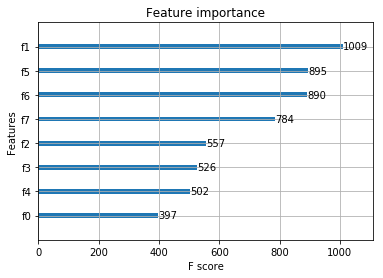

In [28]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# 只需要在模型拟合fit完成之后加入
plot_importance(xgb_clf2)
plt.show()

# 第二部分

# XGBOOST参数调优

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## 1.学习率，估计器数目

In [12]:
#搜索学习率和估计器数目
#其他参数设置为默认值
model1_1 = XGBClassifier(
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)


#网格搜索参数列表
learning_rate = [ 0.001, 0.01, 0.1, 0.2]
n_estimators = [100, 200, 300, 500, 1000]
param1 = dict(learning_rate=learning_rate, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表

#scoring 参数根据实际情况设定，roc_auc 或者 neg_log_loss
grid_search = GridSearchCV(model1_1, param_grid=param1, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
# grid_search = GridSearchCV(model1_1, param_grid=param1, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s


Best: -0.479729 using {'learning_rate': 0.01, 'n_estimators': 300}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished


设置学习率为上述搜索到的学习率的值，具体查看最优化的 估计其数目 是多少

这一步也可以不要，直接使用上述的最好n_estimators

In [13]:
model1_2 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=400,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

eval_set = [(X_test, y_test)]
model1_2.fit(
    X_train, y_train,
    early_stopping_rounds=100, 
    eval_metric="logloss", 
#     eval_metric="auc", 
    eval_set=eval_set, 
    verbose=50)
#verbose是指，每隔50个estimator才打印一次成绩

[0]	validation_0-logloss:0.690588
Will train until validation_0-logloss hasn't improved in 100 rounds.
[50]	validation_0-logloss:0.584058
[100]	validation_0-logloss:0.532183
[150]	validation_0-logloss:0.505183
[200]	validation_0-logloss:0.492587
[250]	validation_0-logloss:0.485973
[300]	validation_0-logloss:0.484974
[350]	validation_0-logloss:0.486333
Stopping. Best iteration:
[282]	validation_0-logloss:0.484596



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)

查看训练出来的模型

在训练集  测试集  上的交叉验证成绩

In [15]:
cv_score_train_test(model1_2)

C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

       neg_log_loss  accuracy        f1   roc_auc
Train      -0.49006  0.764489  0.641571  0.819106
Test       -0.55298  0.692769  0.550016  0.779069


**结论**
- 最佳学习率 0.01 
- 估计其数目 300（282）

**如果scoring参数设置为aoc， **

那么n_estimator=50即可在测试集上获得比较好的成绩


**如果scoring设置为neg_log_loss**

那么需要设置n_estimator需要设置为300左右

## 2. max_depth 和 min_child_weight

In [16]:
#搜索学习率和估计器数目
#其他参数设置为默认值
model2 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=300,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

max_depth = [ i for i in range(1, 6)]
min_child_weight = [i for i in range(4, 8)]
param2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model2, param_grid=param2, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.4s finished


Best: -0.471508 using {'max_depth': 3, 'min_child_weight': 5}


查看模型在训练集、测试集上的交叉验证成绩

In [17]:
cv_score_train_test(grid_search.best_estimator_)

C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

       neg_log_loss  accuracy        f1   roc_auc
Train     -0.475166  0.758758  0.614573  0.830570
Test      -0.521323  0.751385  0.633099  0.803339


**结论：**
- 'max_depth': 3
- 'min_child_weight': 5

## 3.gamma参数调优

In [18]:
model3 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

gamma = [ i/10.0 for i in range(5, 12)]
param3 = dict(gamma=gamma)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model3, param_grid=param3, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: -0.471190 using {'gamma': 0.7}


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    6.1s finished


In [19]:
# 查看模型在训练集、测试集上的交叉验证成绩
cv_score_train_test(grid_search.best_estimator_)

C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

       neg_log_loss  accuracy        f1   roc_auc
Train     -0.475537  0.758758  0.614573  0.829718
Test      -0.520716  0.747385  0.630400  0.803452


## 4.subsample 和 colsample_bytree 参数

In [20]:
model4 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=4,
    min_child_weight=4,
    gamma=0.7,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

subsample = [ i/10.0 for i in range(6, 10)]
colsample_bytree  =  [ i/10.0 for i in range(6, 10)]
param4 = dict(subsample=subsample, colsample_bytree=colsample_bytree)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model4, param_grid=param4, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   10.4s finished


Best: -0.473702 using {'colsample_bytree': 0.7, 'subsample': 0.8}


再次细化上述两个参数

In [21]:
colsample_bytree  =  [ i/100.0 for i in range(65,90,5)]
subsample = [ i/100.0 for i in range(55,95,5)]
param4_2 = dict(subsample=subsample, colsample_bytree=colsample_bytree)

grid_search = GridSearchCV(model4, param_grid=param4_2, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.0s finished


Best: -0.473702 using {'colsample_bytree': 0.65, 'subsample': 0.8}


**结论**

- 'colsample_bytree': 0.65, 
- 'subsample': 0.8

## 5.正则化参数调优

In [22]:
model5 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=4,
    min_child_weight=4,
    gamma=0.7,
    subsample=0.8,
    colsample_bytree=0.65,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
reg_lambda  =  [1e-5, 1e-2, 0.1, 1, 100]
param5 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model5, param_grid=param5, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   12.9s finished


Best: -0.473605 using {'reg_alpha': 0.01, 'reg_lambda': 1}


再次细化上述参数

In [23]:
reg_alpha = [1e-3, 1e-2, 0.1]
reg_lambda  =  [0.1, 1, 10]
param5_2 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)

grid_search = GridSearchCV(model5, param_grid=param5_2, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.0s finished


Best: -0.473605 using {'reg_alpha': 0.01, 'reg_lambda': 1}


**结论：**

- 'reg_alpha': 0.01, 
- 'reg_lambda': 1

## 6.再次降低学习速率

In [24]:
model6 = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    min_child_weight=4,
    gamma=0.7,
    subsample=0.8,
    colsample_bytree=0.65,
    reg_alpha=0.01,
    reg_lambda=1,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

learning_rate = [0.001, 0.01, 0.1, 1]

param6 = dict(learning_rate=learning_rate)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

#网格搜索类，要求的param_grid参数，必须是字典，或者字典构成的列表
grid_search = GridSearchCV(model6, param_grid=param6, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.8s finished


Best: -0.473605 using {'learning_rate': 0.01}


**结论**
学习率=0.01确实是最好的

## 综上，完成所有调参

In [25]:
cv_score_train_test(grid_search.best_estimator_)

C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\TG\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

       neg_log_loss  accuracy        f1   roc_auc
Train     -0.477979  0.756760  0.614948  0.827453
Test      -0.519663  0.739538  0.605151  0.804260


xbg_clf1  model6 模型效果对比
![](https://raw.githubusercontent.com/tangg9646/my_github_image_bed/master/img20191209171001.png)
![](https://raw.githubusercontent.com/tangg9646/my_github_image_bed/master/img20191209171026.png)